# AT-ILS

## Import Library

In [2]:
import requests
import numpy as np
import pandas as pd
import random
import math
import copy
import matplotlib.pyplot as plt

## Download Data

In [3]:
VRP_URL = "https://raw.githubusercontent.com/darrellv14/PAP2/refs/heads/main/belgium-road-time-n50-k10.vrp"
filename = "belgium-road-time-n50-k10.vrp"
response = requests.get(VRP_URL)
with open(filename, "w") as f:
    f.write(response.text)

## Parse Data

In [4]:
def load_vrp_data(filename):
    coords = {}
    demands = {}
    time_matrix = []
    capacity = None
    depot_index_from_file = None
    dimension = None
    with open(filename) as f:
        section = None
        matrix_rows_read = 0
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("DIMENSION"):
                dimension = int(line.split()[-1])
            elif line.startswith("CAPACITY"):
                capacity = int(line.split()[-1])
            elif line == "NODE_COORD_SECTION":
                section = "coords"
                continue
            elif line == "DEMAND_SECTION":
                section = "demands"
                continue
            elif line == "EDGE_WEIGHT_SECTION":
                section = "matrix"
                time_matrix = [[] for _ in range(dimension)]
                continue
            elif line == "DEPOT_SECTION":
                section = "depot"
                continue

            if section == "coords":
                parts = line.split()
                idx = int(parts[0])
                x, y = float(parts[1]), float(parts[2])
                coords[idx] = (x, y)
            elif section == "demands":
                parts = line.split()
                idx = int(parts[0])
                demands[idx] = int(parts[1])
            elif section == "matrix":
                if matrix_rows_read < dimension:
                    row_values = list(map(float, line.split()))
                    time_matrix[matrix_rows_read] = row_values[:dimension]
                    matrix_rows_read += 1
            elif section == "depot":
                if line != "-1" and line != "EOF":
                    depot_index_from_file = int(line)

    node_ids = sorted(list(coords.keys()))

    node_id_to_index = {node_id: i for i, node_id in enumerate(node_ids)}

    demands_list = [demands[node_id] for node_id in node_ids]

    time_matrix = np.array(time_matrix)

    depot_array_index = node_id_to_index[depot_index_from_file] if depot_index_from_file is not None else 0

    return {
        "node_ids": node_ids,
        "coords": np.array([coords[i] for i in node_ids]),
        "demands_map": demands,
        "demands_list": demands_list,
        "time_matrix": time_matrix,
        "capacity": capacity,
        "depot_node_id": depot_index_from_file,
        "depot_index": depot_array_index,
        "node_id_to_index": node_id_to_index
    }

data = load_vrp_data(filename)

total_demand = sum(data["demands_map"].values())
num_vehicles = math.ceil(total_demand / data["capacity"])
print(f"Number of locations (including depot): {len(data['node_ids'])}")
print(f"Vehicle capacity: {data['capacity']}")
print(f"Total demand: {total_demand}")
print(f"Minimum number of vehicles required: {num_vehicles}")



Number of locations (including depot): 50
Vehicle capacity: 125
Total demand: 934
Minimum number of vehicles required: 8


## Utility Functions

In [ ]:
def solution_cost(routes, time_matrix, node_id_to_index):
    total = 0
    for route in routes:
        for i in range(len(route)-1):
            from_node_id = route[i]
            to_node_id = route[i+1]
            # Convert actual node IDs to their 0-indexed positions for time_matrix lookup
            from_idx = node_id_to_index[from_node_id]
            to_idx = node_id_to_index[to_node_id]
            total += time_matrix[from_idx, to_idx]
    return total


In [ ]:
def get_route_demand(route, demands_map):
    """Calculates the total demand for a single route, excluding the depot's demand."""
    total = sum(demands_map[node_id] for node_id in route if node_id != route[0] or (node_id == route[0] and len(route) > 1 and route[0] != route[-1]))
    actual_customer_nodes = route[1:-1]
    total_demand = sum(demands_map[node_id] for node_id in actual_customer_nodes)
    return total_demand

In [ ]:
def is_feasible(route, demands_map, capacity):
    current_demand = get_route_demand(route, demands_map)
    return current_demand <= capacity

In [ ]:
def normalize_routes(routes, depot_node_id):
    """
    Ensures each route starts and ends with the depot, and removes any
    redundant internal depot entries or multiple depots at start/end.
    Ensures empty routes are represented as [depot, depot].
    """
    normalized = []
    for route in routes:
        if not route:
            continue

        customer_nodes = [node for node in route if node != depot_node_id]

        if not customer_nodes:
            normalized.append([depot_node_id, depot_node_id])
        else:
            normalized.append([depot_node_id] + customer_nodes + [depot_node_id])

    if not normalized:
        normalized.append([depot_node_id, depot_node_id])

    return normalized


## Inisialization: Greedy Nearest Neighbor

In [ ]:
def greedy_init(data):
    depot_node_id = data["depot_node_id"]
    all_node_ids = set(data["node_ids"])
    unvisited_node_ids = all_node_ids - {depot_node_id}

    demands_map = data["demands_map"]
    capacity = data["capacity"]
    time_matrix = data["time_matrix"]
    node_id_to_index = data["node_id_to_index"]

    routes = []

    while unvisited_node_ids:
        route = [depot_node_id]
        current_route_demand = 0
        last_node_id = depot_node_id

        while True:
            next_node_id = None
            min_time = float("inf")

            for customer_node_id in unvisited_node_ids:
                customer_demand = demands_map[customer_node_id]

                if current_route_demand + customer_demand > capacity:
                    continue

                last_idx = node_id_to_index[last_node_id]
                customer_idx = node_id_to_index[customer_node_id]

                if time_matrix[last_idx, customer_idx] < min_time:
                    min_time = time_matrix[last_idx, customer_idx]
                    next_node_id = customer_node_id

            if next_node_id is None:
                break

            route.append(next_node_id)
            current_route_demand += demands_map[next_node_id]
            last_node_id = next_node_id
            unvisited_node_ids.remove(next_node_id)

        route.append(depot_node_id)
        routes.append(route)

    return routes


## Local Search

In [ ]:
def two_opt(route, time_matrix, node_id_to_index):
    best_route = list(route)
    improved = True
    while improved:
        improved = False
        for i in range(1, len(best_route) - 2):
            for j in range(i + 1, len(best_route) - 1):
                if j - i == 1: continue

                new_route = best_route[:i] + best_route[i:j][::-1] + best_route[j:]

                current_cost = solution_cost([best_route], time_matrix, node_id_to_index)
                new_cost = solution_cost([new_route], time_matrix, node_id_to_index)

                if new_cost < current_cost:
                    best_route = new_route
                    improved = True
        if not improved:
            break
    return best_route


In [ ]:
def relocate(routes, demands_map, capacity, time_matrix, node_id_to_index, depot_node_id):
    current_routes = copy.deepcopy(routes)
    best_routes_overall = copy.deepcopy(routes)
    best_cost_overall = solution_cost(current_routes, time_matrix, node_id_to_index)

    improvement_found = True
    while improvement_found:
        improvement_found = False

        for i in range(len(current_routes)):
            route_i = current_routes[i]
            if len(route_i) <= 2: continue

            for j in range(1, len(route_i) - 1):
                node_to_move = route_i[j]

                for k in range(len(current_routes)):
                    route_k = current_routes[k]

                    for l in range(1, len(route_k)):
                        temp_routes = copy.deepcopy(current_routes)

                        temp_routes[i].pop(j)

                        if len(temp_routes[i]) == 1:
                            temp_routes[i].append(depot_node_id)
                        elif len(temp_routes[i]) == 0:
                             temp_routes[i] = [depot_node_id, depot_node_id]

                        temp_routes[k].insert(l, node_to_move)

                        test_routes = normalize_routes(temp_routes, depot_node_id)

                        all_feasible = True
                        for r_check in test_routes:
                            if not is_feasible(r_check, demands_map, capacity):
                                all_feasible = False
                                break
                        if not all_feasible:
                            continue

                        cost = solution_cost(test_routes, time_matrix, node_id_to_index)

                        if cost < best_cost_overall:
                            best_cost_overall = cost
                            best_routes_overall = copy.deepcopy(test_routes)
                            improvement_found = True
                            current_routes = copy.deepcopy(best_routes_overall)
                            break
                    if improvement_found: break
                if improvement_found: break
            if improvement_found: break

    return best_routes_overall


In [ ]:
def local_search(routes, demands_map, capacity, time_matrix, node_id_to_index, depot_node_id):
    improved = True
    best_routes = copy.deepcopy(routes)

    while improved:
        improved = False
        current_cost = solution_cost(best_routes, time_matrix, node_id_to_index)

        routes_after_2opt = copy.deepcopy(best_routes)
        for i in range(len(routes_after_2opt)):
            if len(routes_after_2opt[i]) > 3:
                new_route = two_opt(routes_after_2opt[i], time_matrix, node_id_to_index)
                if solution_cost([new_route], time_matrix, node_id_to_index) < solution_cost([routes_after_2opt[i]], time_matrix, node_id_to_index):
                    routes_after_2opt[i] = new_route
                    improved = True

        routes_after_2opt = normalize_routes(routes_after_2opt, depot_node_id)
        cost_after_2opt = solution_cost(routes_after_2opt, time_matrix, node_id_to_index)

        if cost_after_2opt < current_cost:
            best_routes = copy.deepcopy(routes_after_2opt)
            current_cost = cost_after_2opt
            improved = True

        routes_after_relocate = relocate(best_routes, demands_map, capacity, time_matrix, node_id_to_index, depot_node_id)
        routes_after_relocate = normalize_routes(routes_after_relocate, depot_node_id)
        cost_after_relocate = solution_cost(routes_after_relocate, time_matrix, node_id_to_index)

        if cost_after_relocate < current_cost:
            best_routes = copy.deepcopy(routes_after_relocate)
            improved = True

    return best_routes


## Peturbation

In [ ]:
def perturb(routes, k, demands_map, capacity, time_matrix, node_id_to_index, depot_node_id):
    routes = copy.deepcopy(routes)
    all_customer_nodes = []

    customer_node_to_route_idx = {}
    for r_idx, route in enumerate(routes):
        for node_id in route[1:-1]:
            all_customer_nodes.append(node_id)
            customer_node_to_route_idx[node_id] = r_idx

    k = min(k, len(all_customer_nodes))

    if k == 0:
        return routes

    to_perturb_nodes = random.sample(all_customer_nodes, k)

    # Remove selected nodes from their current routes
    for node_id in to_perturb_nodes:
        original_route_idx = customer_node_to_route_idx[node_id]
        routes[original_route_idx].remove(node_id)

    # Insert perturbed nodes back into random feasible positions
    for node_id in to_perturb_nodes:
        inserted = False
        attempts = 0
        while not inserted and attempts < 200:
            if not routes:
                routes.append([depot_node_id, depot_node_id])

            target_route_idx = random.randint(0, len(routes) - 1)
            target_route = routes[target_route_idx]

            if len(target_route) == 1 and target_route[0] == depot_node_id:
                target_route.append(depot_node_id)

            if len(target_route) > 1:
                insert_pos = random.randint(1, len(target_route) - 1)
            else:
                insert_pos = 1

            temp_target_route = list(target_route)
            temp_target_route.insert(insert_pos, node_id)

            if is_feasible(temp_target_route, demands_map, capacity):
                routes[target_route_idx].insert(insert_pos, node_id)
                inserted = True
            attempts += 1

        if not inserted:
            new_route_for_node = [depot_node_id, node_id, depot_node_id]
            if is_feasible(new_route_for_node, demands_map, capacity):
                routes.append(new_route_for_node)
            else:
                print(f"Warning: Node {node_id} cannot be inserted into any route (even a new one) due to capacity.")

    final_routes = normalize_routes(routes, depot_node_id)

    return final_routes


## AT-ILS

In [ ]:
THRESH0 = 0.9
DECAY = 0.999
MAX_ITERS = 5000
PERTURB_INTERVAL = 10
PERTURB_K = 3

# Initial solution
routes = greedy_init(data)
routes = normalize_routes(routes, data["depot_node_id"]) # <--- Normalize initial routes

current_cost = solution_cost(routes, data["time_matrix"], data["node_id_to_index"])
best_cost = current_cost
best_routes = copy.deepcopy(routes)
T = THRESH0 * current_cost

costs_history = [best_cost]

def print_route_table(route_id, route, data):
    """
    Prints a single route in a tabular format.
    Assumes data contains 'node_ids', 'demands_map', 'time_matrix',
    'depot_node_id', and 'node_id_to_index'.
    """
    depot_node_id = data["depot_node_id"]

    print(f"\nKendaraan {route_id} - Rute:")
    table_data = []
    cumulative_demand = 0
    cumulative_time = 0.0

    node_names_map = {node_id: str(node_id) for node_id in data["node_ids"]}
    if depot_node_id is not None:
        node_names_map[depot_node_id] = "BRUSSEL"

    prev_node_id = None

    for i, node_id in enumerate(route):
        node_name = node_names_map.get(node_id, f"Node {node_id}")

        node_demand_for_step = data["demands_map"].get(node_id, 0)

        # Calculate travel time to current node
        time_to_current_node = 0.0
        if prev_node_id is not None:
            prev_idx = data["node_id_to_index"][prev_node_id]
            current_idx = data["node_id_to_index"][node_id]
            time_to_current_node = data["time_matrix"][prev_idx, current_idx]

        if node_id == depot_node_id:
            cumulative_demand = 0
        else:
            cumulative_demand += node_demand_for_step

        cumulative_time += time_to_current_node

        table_data.append({
            "Urutan": i,
            "Node ID": node_id,
            "Nama Node": node_name,
            "Permintaan (Node)": node_demand_for_step,
            "Muatan Kumulatif": cumulative_demand,
            "Waktu ke Node Ini (detik)": f"{time_to_current_node:.5f}",
            "Waktu Kumulatif (detik)": f"{cumulative_time:.5f}"
        })
        prev_node_id = node_id

    df = pd.DataFrame(table_data)
    print(df.to_string(index=False))

    final_route_demand = get_route_demand(route, data["demands_map"])

    print(f"Total Waktu Rute: {cumulative_time:.2f} detik")
    print(f"Total Permintaan Rute: {final_route_demand}")
    print(f"Muatan Maksimum Rute: {final_route_demand} (Kapasitas: {data['capacity']})")
    is_route_feasible = "True" if final_route_demand <= data["capacity"] else "False"
    print(f"Rute ini Layak (Kapasitas): {is_route_feasible}")


print("Starting AT-ILS...\n")

for iteration in range(MAX_ITERS):
    # Local search
    candidate = local_search(routes, data["demands_map"], data["capacity"], data["time_matrix"], data["node_id_to_index"], data["depot_node_id"])
    cand_cost = solution_cost(candidate, data["time_matrix"], data["node_id_to_index"])

    if cand_cost < current_cost or (T > 0 and random.random() < math.exp(-(cand_cost - current_cost) / T)):
        routes = copy.deepcopy(candidate)
        current_cost = cand_cost
        if current_cost < best_cost:
            best_cost = current_cost
            best_routes = copy.deepcopy(routes)

    # Update threshold
    T *= DECAY

    # Perturb
    if (iteration + 1) % PERTURB_INTERVAL == 0:
        routes = perturb(routes, PERTURB_K, data["demands_map"], data["capacity"], data["time_matrix"], data["node_id_to_index"], data["depot_node_id"])
        current_cost = solution_cost(routes, data["time_matrix"], data["node_id_to_index"])

        if current_cost < best_cost:
            best_cost = current_cost
            best_routes = copy.deepcopy(routes)

    costs_history.append(best_cost)

    # --- Display results for each iteration ---
    if (iteration + 1) % 100 == 0 or iteration == 0 or iteration == MAX_ITERS - 1:
        print(f"\n--- Iterasi {iteration + 1}/{MAX_ITERS} ---")
        print(f"Best solution cost so far: {best_cost:.2f} detik")
        print(f"Current Threshold (T): {T:.5f}")

print("\n\n--- Optimization Finished ---")
print(f"Best solution cost found: {best_cost:.2f} detik")

print("\n--- Best Routes Details (Tabular Format) ---")
for idx, r in enumerate(best_routes):
    if len(r) > 2 or (len(r) == 2 and r[0] == r[1] == data["depot_node_id"]):
        print_route_table(idx + 1, r, data)
    else:
        print(f"Route {idx+1}: Invalid or truly empty route. Skipping printing. Route content: {r}")


Starting AT-ILS...


--- Iterasi 1/5000 ---
Best solution cost so far: 138151.86 detik
Current Threshold (T): 138009.24081

--- Iterasi 100/5000 ---
Best solution cost so far: 132505.27 detik
Current Threshold (T): 124994.67199

--- Iterasi 200/5000 ---
Best solution cost so far: 126940.27 detik
Current Threshold (T): 113094.19765

--- Iterasi 300/5000 ---
Best solution cost so far: 122902.89 detik
Current Threshold (T): 102326.74191

--- Iterasi 400/5000 ---
Best solution cost so far: 122902.89 detik
Current Threshold (T): 92584.43252

--- Iterasi 500/5000 ---
Best solution cost so far: 117848.18 detik
Current Threshold (T): 83769.66749

--- Iterasi 600/5000 ---
Best solution cost so far: 117848.18 detik
Current Threshold (T): 75794.13731

--- Iterasi 700/5000 ---
Best solution cost so far: 117848.18 detik
Current Threshold (T): 68577.94024

--- Iterasi 800/5000 ---
Best solution cost so far: 117848.18 detik
Current Threshold (T): 62048.78179

--- Iterasi 900/5000 ---
Best solution co

## Visualization

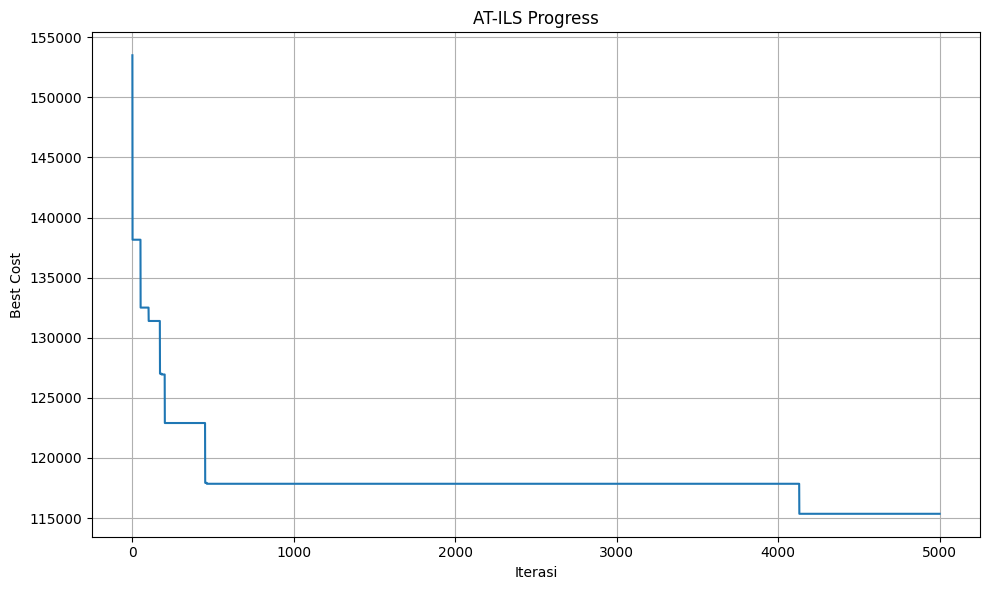

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(costs_history)
plt.xlabel('Iterasi')
plt.ylabel('Best Cost')
plt.title('AT-ILS Progress')
plt.grid(True)
plt.tight_layout()
plt.savefig('AT-ILS_Progress.png') # Save the plot as a PNG file
plt.show() # Display the plot

In [ ]:
def plot_routes(routes, coords, depot_node_id, node_id_to_index):
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap("tab20", len(routes))

    # Plot all nodes
    for node_id in data["node_ids"]:
        idx = node_id_to_index[node_id]
        x, y = coords[idx]
        if node_id == depot_node_id:
            plt.scatter(x, y, c='red', marker='s', s=100, zorder=5, label="Depot")
        else:
            plt.scatter(x, y, c='black', s=30, zorder=4)

    # Plot each route
    for idx, route in enumerate(routes):
        route_indices = [node_id_to_index[node_id] for node_id in route]
        route_coords = coords[route_indices]

        plt.plot(route_coords[:, 0], route_coords[:, 1],
                 marker='o', linestyle='-', linewidth=1.5,
                 label=f'Route {idx+1}', color=colors(idx), zorder=3)

    plt.title("Best VRP Routes Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-27-470662526.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(routes))


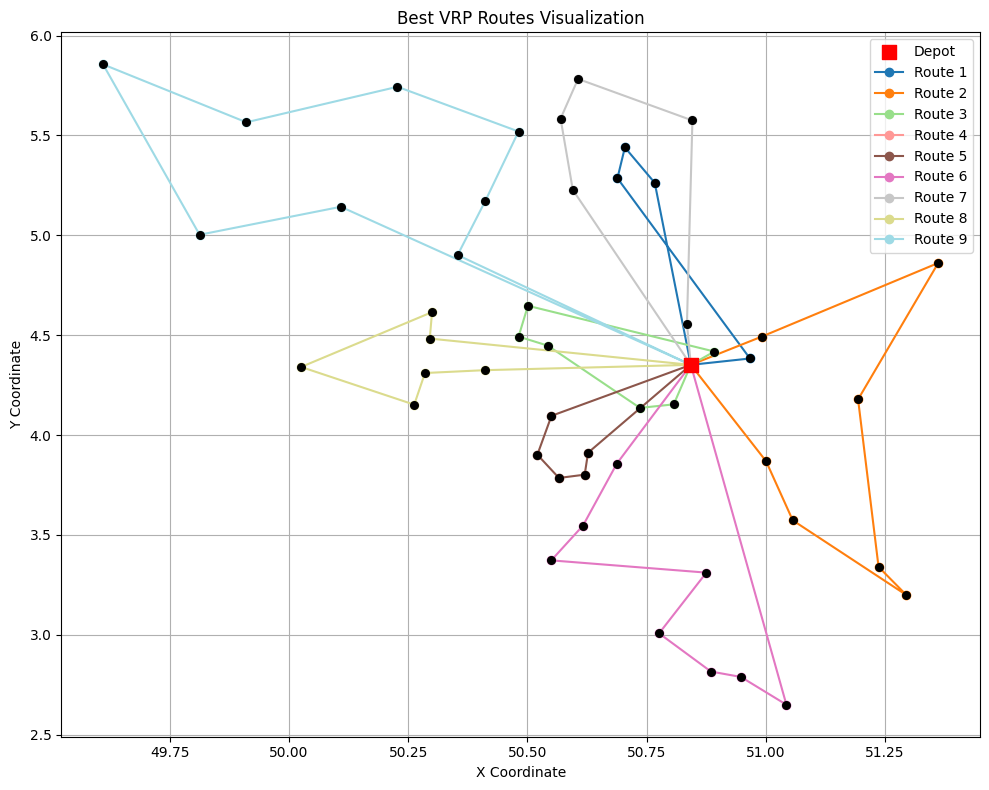

In [ ]:
plot_routes(best_routes, data["coords"], data["depot_node_id"], data["node_id_to_index"])

# OR Tools

## Import Library

In [4]:
!pip install ortools

In [5]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

## Solve with OR-Tools

In [6]:
def solve_vrp_with_or_tools(data):
    manager = pywrapcp.RoutingIndexManager(len(data["node_ids"]),  # jumlah lokasi
                                           300,  # max number of vehicles
                                           data["depot_index"])  # index depot (array index)

    routing = pywrapcp.RoutingModel(manager)

    # Cost callback (berdasarkan time_matrix)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(data["time_matrix"][from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Capacity constraint
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands_list"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # slack
        [data["capacity"]] * 300,  # kapasitas kendaraan
        True,  # start cumul to zero
        "Capacity"
    )

    # Search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30
    search_parameters.log_search = True

    # Run solver
    solution = routing.SolveWithParameters(search_parameters)

    return routing, manager, solution

In [ ]:
routing, manager, solution = solve_vrp_with_or_tools(data)

## Visualization

In [8]:
def get_routes(routing, manager, solution):
    routes = []
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            index = solution.Value(routing.NextVar(index))
        if len(route) > 1:
            route.append(manager.IndexToNode(index))
            routes.append(route)
    return routes

def plot_routes(data, routes):
    import matplotlib.pyplot as plt

    coords = data["coords"]
    plt.figure(figsize=(10, 6))
    for i, route in enumerate(routes):
        x = [coords[node][0] for node in route]
        y = [coords[node][1] for node in route]
        plt.plot(x, y, marker='o', label=f"Vehicle {i+1}")
        for j, node in enumerate(route):
            plt.text(coords[node][0], coords[node][1], str(data["node_ids"][node]), fontsize=8)

    depot = data["coords"][data["depot_index"]]
    plt.scatter([depot[0]], [depot[1]], c='red', s=100, label="Depot")
    plt.title("Vehicle Routes")
    plt.legend()
    plt.grid()
    plt.show()


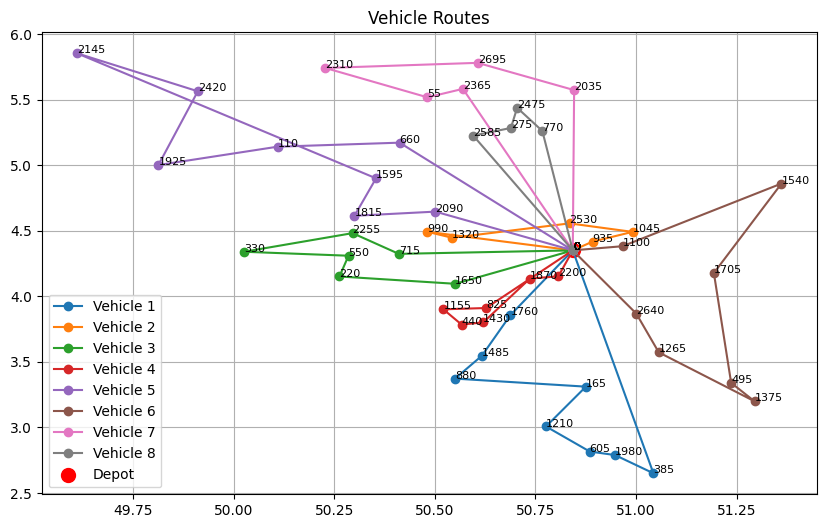

Total cost (objective value): 117456
Route 1: [0, 1760, 1485, 880, 165, 1210, 605, 1980, 385, 0]
Route 2: [0, 935, 1045, 2530, 1320, 990, 0]
Route 3: [0, 715, 2255, 330, 550, 220, 1650, 0]
Route 4: [0, 825, 1155, 440, 1430, 1870, 2200, 0]
Route 5: [0, 2090, 1815, 1595, 2145, 2420, 1925, 110, 660, 0]
Route 6: [0, 2640, 1265, 1375, 495, 1705, 1540, 1100, 0]
Route 7: [0, 2365, 55, 2310, 2695, 2035, 0]
Route 8: [0, 770, 2475, 275, 2585, 0]


In [9]:
if solution:
    routes = get_routes(routing, manager, solution)
    plot_routes(data, routes)

    print("Total cost (objective value):", solution.ObjectiveValue())
    for i, route in enumerate(routes):
        actual_node_ids = [data["node_ids"][idx] for idx in route]
        print(f"Route {i+1}: {actual_node_ids}")
else:
    print("No solution found.")